# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

# Convolutional Neural Network

## Ziel: 
### Training vom ersten Model mit [Cloud Computing Power](https://neptune.ml/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
import numpy as np
from scipy.misc import imresize

from __future__ import unicode_literals # bc of ü, ö, ä ...

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.
/Users/Muriz/.virtualenvs/ml/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Kategorien die sich ähneln oder keinen Mehwert ergeben (z.B "griechische", "weisse", "blech",...) werden gelöscht. Es bleiben noch 230 Kategorien

In [36]:
!ls input/images/images/

blechkuchen         gegrillte           marmorkuchen        rote_bete
blumenkohl          geschnetzeltes      marzipan            rouladen
bohnen              gnocchi             mascarpone          rucola
bohnensalat         gratin              maultaschen         rucolasalat
bohnensuppe         gugelhupf           milchreis           sahne
bolognese           gulasch             mohn                salat
bowle               gurken              mohnkuchen          salatdressing
bratkartoffeln      gurkensalat         mousse_au_chocolat  sauce
brokkoli            gyros               mozzarella          sauerkraut
brot                hackbraten          muffins             schinken
brotaufstrich       hackfleisch         neptune.log         schnitten
brownies            heidelbeer          nougat_pralinen     schnitzel
bruschetta          himbeer             nudelauflauf        schoko
burger              honig_senf          nudeln              schokoladenkuchen
butter              huhn 

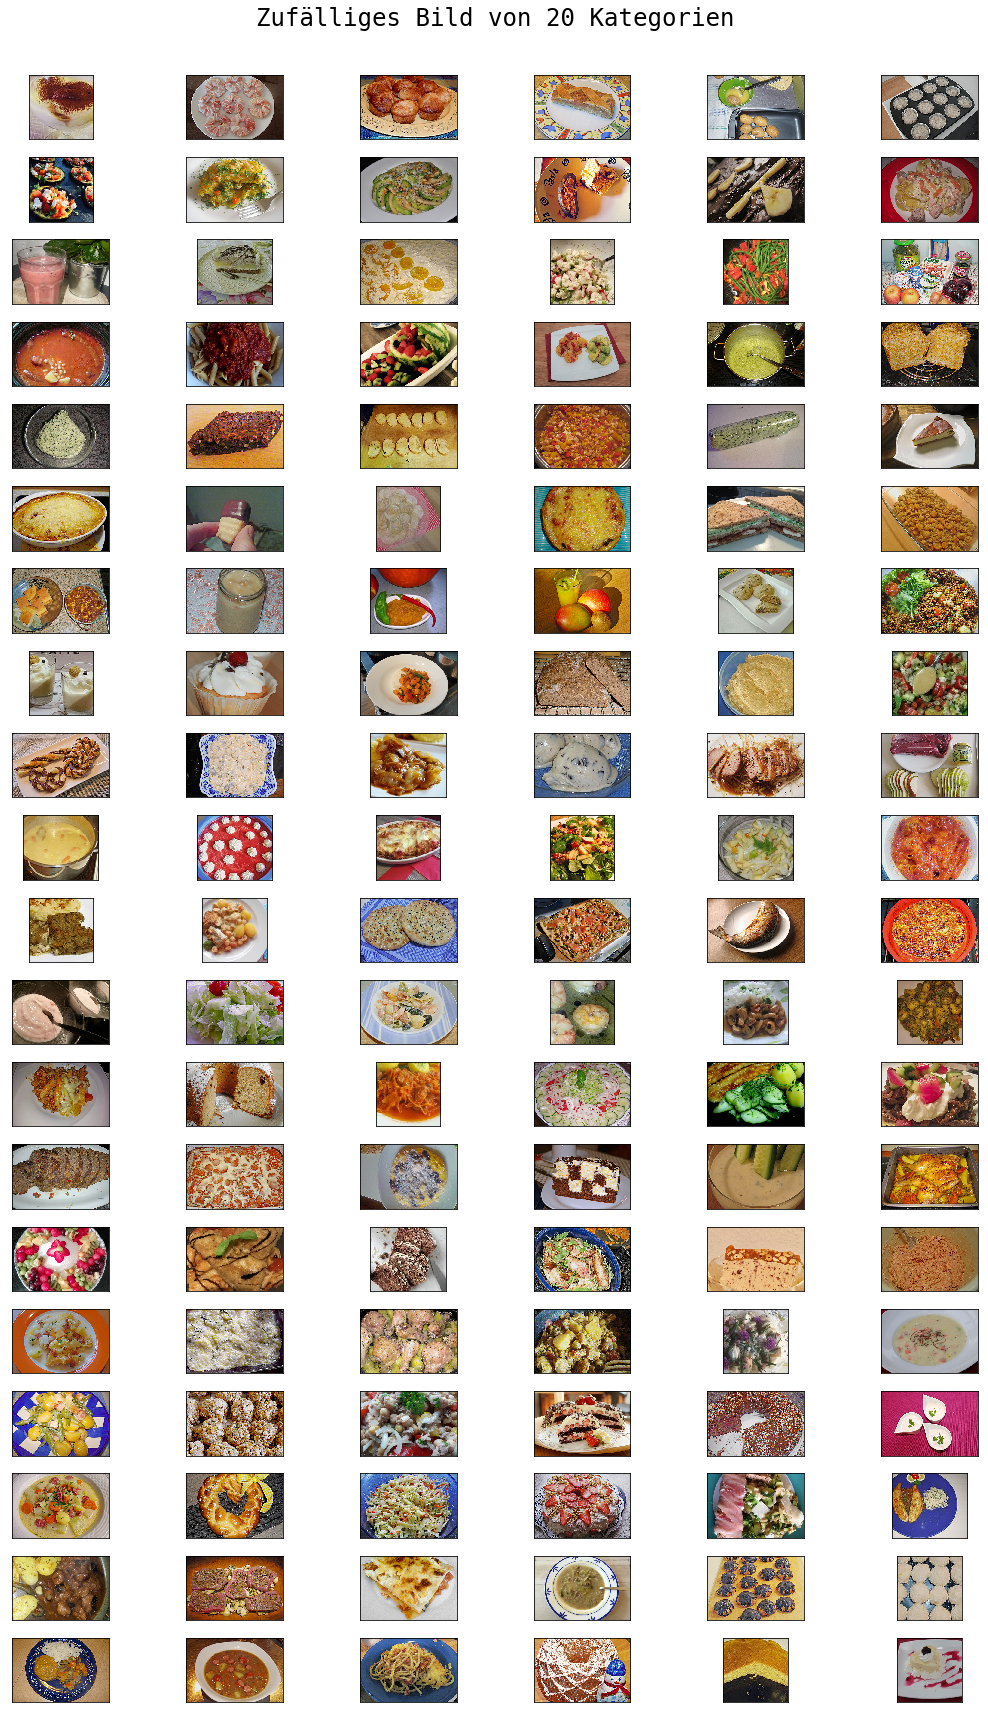

In [3]:
matplotlib.rc('font',family='monospace')
plt.style.use('seaborn-poster')

root_dir = 'input/images/images/'
rows = 20
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Zufälliges Bild von 20 Kategorien', fontsize=24)
ingore_files = ['.DS_Store', 'neptune.log']
sorted_food_dirs = [fd for fd in sorted(os.listdir(root_dir)) if not fd in ingore_files]

for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (.7, 0, 0)
        fc = (0.9, 0, 0)
        ax[i][j].text(0, -18, food_dir, size=0, rotation=0,
                ha="center", va="center", color='w',)
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [45]:
import multiprocessing as mp
num_processes = 8
pool = mp.Pool(processes=num_processes)

In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Using TensorFlow backend.
/Users/Muriz/.virtualenvs/ml/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
import psutil
psutil.virtual_memory()

In [ ]:
root = '/input/images'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

num_image_counter = 0
# load all the images from root folder
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        if num_image_counter > 10000: break
        num_image_counter +=1
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

In [ ]:
import pickle
with open('/output/rec_images.pkl', 'wb') as f:
    pickle.dump(data, f)

num_classes = len(categories)

random.shuffle(data)

# training / validation / test split (70%, 15%, 15%)
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]
del data

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

In [ ]:
inp = vgg.input

new_classification_layer = Dense(num_classes, activation='softmax')

out = new_classification_layer(vgg.layers[-2].output)

model_new = Model(inp, out)

for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model_new.summary()

In [ ]:
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="/output/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model_new.fit(x_train, y_train, 
                         batch_size=32, 
                         epochs=100, 
                         validation_data=(x_val, y_val),
                        callbacks=callbacks_list,
                        verbose=1)

In [ ]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("/output/acc_1.png")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("/output/loss_2.png")

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
img, x = get_image('pred.jpg')
probabilities = model_new.predict([x])
print(probabilities)

In [ ]:
print(np.argmax(probabilities))

In [ ]:
categories[3]

In [ ]:
categories